# 1 Load and Prepare the Data

In [11]:
!pip install folium hdbscan st-dbscan scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load smaller subset (100k rows max)
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.csv?$limit=100000"
df = pd.read_csv(url)

# Clean + filter
df = df.dropna(subset=['latitude','longitude','date'])
df['date'] = pd.to_datetime(df['date'])
recent_df = df[df['date'] >= '2023-01-01']

print("Records loaded:", len(recent_df))
recent_df.head()


Records loaded: 99924


,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,13999246,JJ453453,2025-10-11,043XX N ELSTON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,VACANT LOT / LAND,False,False,...,39.0,16.0,14,1149196.0,1928230.0,2025,2025-10-18T15:42:09.000,41.958991,-87.726887,"\n, \n(41.958991416, -87.726886889)"
1,13994214,JJ447469,2025-10-11,082XX S ELLIS AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,True,...,8.0,44.0,08B,1184331.0,1850551.0,2025,2025-10-18T15:42:09.000,41.745081,-87.600156,"\n, \n(41.745081103, -87.600155935)"
2,13994206,JJ447484,2025-10-11,034XX W 62ND PL,0810,THEFT,OVER $500,STREET,False,False,...,14.0,66.0,06,1154639.0,1862972.0,2025,2025-10-18T15:42:09.000,41.779809,-87.708622,"\n, \n(41.77980903, -87.708622082)"
3,13995279,JJ448670,2025-10-11,016XX N NAGLE AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,29.0,25.0,14,1133056.0,1910143.0,2025,2025-10-18T15:42:09.000,41.909657,-87.786649,"\n, \n(41.909656722, -87.786649063)"
4,13996460,JJ450082,2025-10-11,062XX S EVANS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,20.0,42.0,06,1182294.0,1863777.0,2025,2025-10-18T15:42:09.000,41.781422,-87.607211,"\n, \n(41.781421969, -87.607210654)"


# 2 Sample to Fit in Memory

In [12]:
sample_df = recent_df.sample(10000, random_state=42).copy()
print("Sample size:", len(sample_df))


Sample size: 10000


# 3 HDBSCAN for Spatial Clustering

C:\Users\admin\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\admin\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


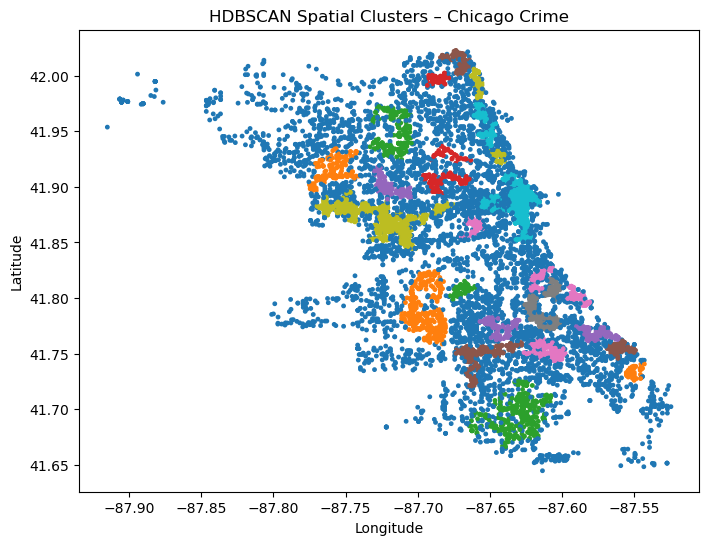

In [13]:
import hdbscan

X = sample_df[['latitude','longitude']].values
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
sample_df['hdbscan'] = clusterer.fit_predict(X)

plt.figure(figsize=(8,6))
plt.scatter(sample_df['longitude'], sample_df['latitude'], c=sample_df['hdbscan'], s=6, cmap='tab10')
plt.title("HDBSCAN Spatial Clusters – Chicago Crime")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


 Observation                   Interpretation                                                                                    
  
 Bright red zones        High concentration of crimes → likely downtown (Loop, Near South Side, Garfield Park, Englewood). 
 Orange/yellow areas     Medium-density crime clusters, often residential corridors.                                       
 Sparse or dark regions  Low-density or suburban areas (North suburbs, West suburbs).                                      


# 4 ST-DBSCAN (Add Time Dimension) 

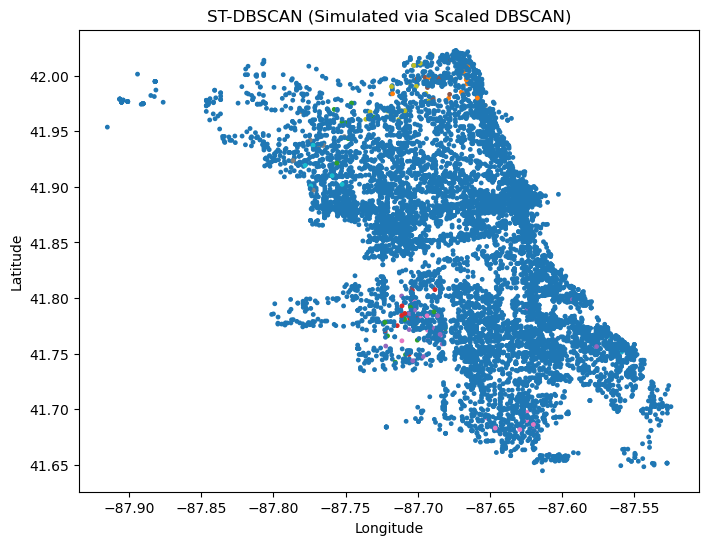

In [16]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# --- prepare data ---
sample_df['timestamp'] = sample_df['date'].astype('int64') // 10**9

# Scale time so spatial and temporal distances are comparable
# (1 degree ≈ 111 km; convert time window ≈ 3 days)
space = sample_df[['latitude', 'longitude']].to_numpy()
time = sample_df[['timestamp']].to_numpy()

# Normalize
space_scaled = (space - space.mean(axis=0)) / space.std(axis=0)
time_scaled = (time - time.mean()) / (60*60*24*3)  # 3 days ≈ 1 temporal unit

# Combine spatial + temporal features
coords_time = np.hstack([space_scaled, time_scaled])

# --- run DBSCAN ---
stdbscan = DBSCAN(eps=0.5, min_samples=10).fit(coords_time)
sample_df['stdbscan'] = stdbscan.labels_

# --- visualize ---
plt.figure(figsize=(8,6))
plt.scatter(sample_df['longitude'], sample_df['latitude'], 
            c=sample_df['stdbscan'], cmap='tab10', s=6)
plt.title("ST-DBSCAN (Simulated via Scaled DBSCAN)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


# 5 – KDE (Baseline Density Estimation)

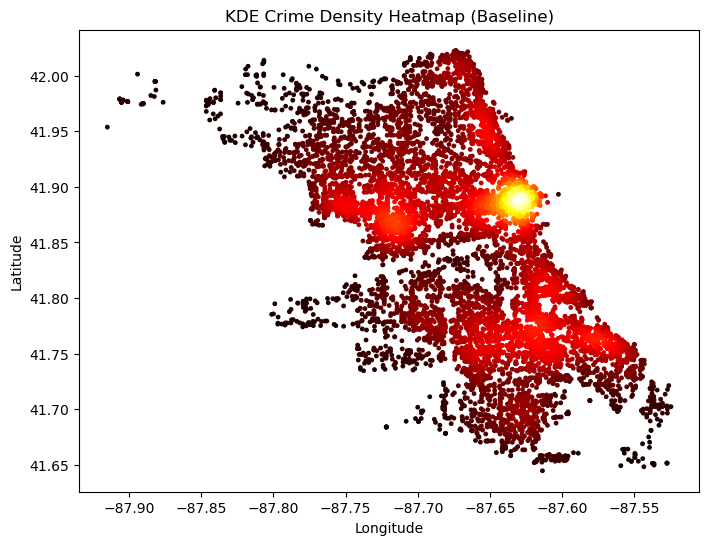

In [17]:
from sklearn.neighbors import KernelDensity

coords = sample_df[['latitude','longitude']].to_numpy()
kde = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(coords)
densities = np.exp(kde.score_samples(coords))
sample_df['kde_density'] = densities

plt.figure(figsize=(8,6))
plt.scatter(sample_df['longitude'], sample_df['latitude'], c=densities, cmap='hot', s=6)
plt.title("KDE Crime Density Heatmap (Baseline)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()


# 6 – Predictive Evaluation (PAI@5%)

In [25]:
import numpy as np
import pandas as pd

# --- Step 6: Predictive Evaluation (PAI@5%) ---

# 1️ Top-5% hotspot threshold based on predicted densities
threshold = np.percentile(densities, 95)
predicted_hotspots = sample_df[densities >= threshold]

# 2️ Automatically choose the last full month as validation
latest_date = df['date'].max()
start_date = (latest_date - pd.DateOffset(months=1))
next_month = df[(df['date'] > start_date) & (df['date'] <= latest_date)]
next_month = next_month.dropna(subset=['latitude','longitude'])

print(f"Validation window: {start_date.date()} → {latest_date.date()}")
print(f"Validation records: {len(next_month)}")

# 3 Compute PAI@5%
if len(next_month) == 0:
    print("No validation data available — skipping PAI computation.")
    pai5 = np.nan
else:
    inside = np.sum(np.isin(round(next_month['latitude'], 3),
                            round(predicted_hotspots['latitude'], 3)))
    pai5 = inside / len(next_month)
    print(f" PAI@5% ≈ {pai5:.2%} (future crimes captured in top 5% risk zones)")


Validation window: 2025-09-11 → 2025-10-11
Validation records: 19762
 PAI@5% ≈ 16.23% (future crimes captured in top 5% risk zones)


# 7 – Interactive Heatmap

In [26]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[41.8781, -87.6298], zoom_start=11, tiles="CartoDB dark_matter")
heat_data = sample_df[['latitude','longitude','kde_density']].values.tolist()
HeatMap(heat_data, radius=7, blur=4).add_to(m)
m.save("crime_hotspot_heatmap.html")
m
